#### 시작

In [2]:
from dotenv import load_dotenv

import cv2
import os
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

from pathlib import Path

import json

- .env라는 파일을 먼저 만들고, 기본 베이스 경로(root_path)를 .env가 들어있는 부모폴더로 해놓았습니다.
    - 따라서 .env(파일이름이 .env입니다.)를 먼저 만들어주시고 .env가 들어있는 폴더에 data폴더를 만들어주시고 그 안에 저희에게 주어진 json 파일과 images폴더가 있고 images폴더 안에 이미지 600장이 들어있는 구조이면 문제없이 작동할 것으로 보입니다!
- 자세한 폴더 구조는 저희 팀 깃허브 페이지에 들어가시면 리드미에서 구조도를 보실 수 있습니다.

In [5]:
class PathManager:
    """환경 및 모듈 간 규격 클래스"""
    """상황에 맞게 경로와 규격을 수정 후 사용할 것"""
    
    def __init__(self, default_size: int | None = None):
        """dotenv 위치 찾기 + 로드"""
        self.root_path = self._find_root()
        self.dotenv_path = self.root_path / ".env" # 또는 self.dotenv_path = self.root_path / ".env"
        load_dotenv(self.dotenv_path)

        """이미지와 모델 디렉토리 인식"""
        self._images_dir = self.root_path / "data/images"
        self._models_dir = self.root_path / "models"
        self._datas_dir = self.root_path / "data"
        self.default_size = default_size

        self.image_name = None
        self.model_name = None

    def _find_root(self, marker: str=".env") -> Path: # 외부에서 호출할 일 없다.
        """프로젝트 최상단 경로를 찾는 함수"""
        """.env를 마커로 사용"""
        current_cwd = Path().cwd().resolve()
        for parent in current_cwd.parents:
            if (parent / marker).exists():
                return parent

    def get_image_path(self, image_name: str) -> Path:
        """이미지 주소 획득"""
        self.image_name = image_name
        return self._images_dir / image_name
        
    def get_model_path(self, model_name: str) -> Path:
        """모델 주소 획득"""
        self.model_name = model_name
        return self._models_dir / model_name

    def get_data_path(self, data_name: str) -> Path:
        """데이터 주소 획득"""
        self.data_name = data_name
        return self._datas_dir / data_name

def run():
    """앞으로 작업할 모든 작업에서 쓰는 경로 반환 함수"""
    path_manager = PathManager()

    # 기본 경로, 이미지 폴더 경로, 데이터 폴더 경로
    root_path = path_manager.root_path
    images_dir = path_manager._images_dir
    data_dir = path_manager._datas_dir

    # 이미지 폴더 내의 이미지 경로
    my_image_path = path_manager.get_image_path("night ride (7).png")
    
    # 원본
    my_image_origin = cv2.imread(my_image_path)
    
    # 원본을 rgb로 변환 후 변수 저장
    my_image_rgb = cv2.cvtColor(my_image_origin, cv2.COLOR_BGR2RGB)

    # json 경로
    my_json_path = path_manager.get_data_path("COCO_motorcycle (pixel).json")
    
    # json 로드
    with open (my_json_path, "r", encoding="utf-8") as f:
        my_json_origin = json.load(f)

    return root_path, images_dir, data_dir, my_json_origin

# root_path: .env 파일의 부모 폴더, images_dir: 이미지 폴더 주소, data_dir: 데이터 폴더 주소, my_json_origin: json파일 객체
root_path, images_dir, data_dir, my_json_origin = run()

#### 폴더에 있는 이미지 파일 가져오기

In [ ]:
import os

# 1. 이미지 폴더 내의 모든 파일 리스트업
# PathManager의 속성을 활용합니다.
all_files = os.listdir(images_dir)

# 2. 이미지 확장자만 필터링 (순서가 달라도 상관없습니다, 이름으로 매칭할 거니까요)
valid_extensions = ('.png', '.jpg', '.jpeg')
image_files = [f for f in all_files if f.lower().endswith(valid_extensions)]

print(f"찾은 이미지 개수: {len(image_files)}장") # 여기서 200이 나와야 합니다.

찾은 이미지 개수: 600장


#### 폴더에 있는 이미지 파일 중 save랑 fuse 제외하고 가져오기

In [11]:
# 1. 'save'와 'fuse'가 이름에 들어간 파일은 제외하고 순수 'night ride'와 'Screenshot'만 추출
# 리스트 컴프리헨션을 사용하여 조건부 필터링을 수행합니다.
image_files = [
    f for f in all_files 
    if f.lower().endswith(valid_extensions)
    and 'save' not in f.lower() 
    and 'fuse' not in f.lower()
]

print(f"정제된 이미지 개수: {len(image_files)}장") 
# 여기서 정확히 200장이 나오는지 확인하십시오.

print(image_files[99])

정제된 이미지 개수: 200장
Screenshot (317).png


#### JSON과 입력파일이 실제로 매칭하는지 확인해서 매칭된것만 가져오기

In [12]:
# JSON에 등록된 모든 파일 이름을 집합(Set)으로 만듭니다. (검색 속도 최적화)
json_filenames = {img['file_name'] for img in my_json_origin['images']}

# 폴더에는 있지만 JSON에는 없는 유령 파일들을 걸러냅니다.
final_image_files = [f for f in image_files if f in json_filenames]

print(f"최종 매칭된 이미지 개수: {len(final_image_files)}장")

최종 매칭된 이미지 개수: 200장


In [ ]:
from sklearn.model_selection import train_test_split

# 0. 팀원들끼리 공유할떄 시드값이 고정되어도 기본 파일정렬은 os마다 다를 수 있습니다. 그래서 추가했습니다.
final_image_files = sorted(final_image_files)

# 1. 전체 200장에서 먼저 Test 20장(10%)을 분리합니다.
# 200 * 0.1 = 20
train_val_files, test_files = train_test_split(
    final_image_files, 
    test_size=0.1, 
    random_state=2026
)

# 2. 남은 180장에서 다시 Val 20장(약 11.1%)을 분리합니다.
# 180 * (20/180) = 20
train_files, val_files = train_test_split(
    train_val_files, 
    test_size=20/180, 
    random_state=2026
)

print(f"✅ 분리 완료 (Seed: 2026)")
print(f"훈련 데이터(Train): {len(train_files)}장")
print(f"검증 데이터(Val): {len(val_files)}장")
print(f"테스트 데이터(Test): {len(test_files)}장")

✅ 분리 완료 (Seed: 2026)
훈련 데이터(Train): 160장
검증 데이터(Val): 20장
테스트 데이터(Test): 20장


#### 데이터셋 정의

In [24]:
import cv2
import torch
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset


# 0번부터 5번까지 6개 클래스를 할당, 배경도 언Undrivable에 포함
CLASS_MAP = {
    'Undrivable': 0,
    'Road': 1,
    'Lane Mark': 2,
    'My bike': 3,
    'Rider': 4,
    'Moveable': 5
}
# 역매핑 (ID -> Name)은 필요할 때 내부에서 생성하거나 별도로 정의
ID_TO_NAME = {v: k for k, v in CLASS_MAP.items()}


class DeepLabDataset(Dataset):
    """데이터셋, 이미지 및 마스크크 리사이즈, 정규화, 텐서화 """

    def __init__(self, image_paths, json_data, class_map):
        self.image_paths = image_paths
        self.json_data = json_data
        self.class_map = class_map
        
        # 520x520 리사이즈 및 텐서 변환
        self.transform = A.Compose([
            A.Resize(528, 528, interpolation=cv2.INTER_LINEAR),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])
        
        # 마스크 전용 리사이즈 (정수 값 유지를 위해 별도 처리하거나 Compose 내에서 mask_interpolation 설정)
        self.mask_resize = A.Resize(528, 528, interpolation=cv2.INTER_NEAREST)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        """마스크 제너레이터 함수로 마스크 생성, 이미지와 마스크에 리사이즈 및 정규화 적용"""
        image_path = self.image_paths[idx]
        
        # 1. 원본 이미지 로드 및 bgr2rgb
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 2. 마스크 생성 (기존에 정의한 6개 클래스 로직)
        # 2. 1920x1080 원본 크기로 먼저 생성
        full_mask = self._generate_full_mask(image_path.name, (1080, 1920))

        # 3. 이미지와 마스크 동시 변환 -> Resize(528, 528) 적용
        transformed = self.mask_resize(image=image, mask=full_mask)
        transformed = self.transform(image=transformed['image'], mask=transformed['mask'])

        return transformed['image'], transformed['mask'].long()

    def _generate_full_mask(self, file_name, shape):
        """JSON의 좌표를 기반으로 1080x1920 마스크 생성"""
        mask = np.zeros(shape, dtype=np.uint8)
        
        # 1. file_name으로 image_id 찾기
        image_info = next((img for img in self.json_data['images'] if img['file_name'] == file_name), None)
        if image_info is None:
            return mask
        
        image_id = image_info['id']
        
        # 2. 해당 image_id를 가진 모든 annotation 가져오기
        annotations = [ann for ann in self.json_data['annotations'] if ann['image_id'] == image_id]
        
        # 3. 카테고리 ID -> 이름 -> 인덱스(0~5) 매핑
        category_id_to_name = {cat['id']: cat['name'] for cat in self.json_data['categories']}
        
        for ann in annotations:
            cat_name = category_id_to_name.get(ann['category_id'])
            label_idx = self.class_map.get(cat_name)
            
            if label_idx is not None:
                for seg in ann['segmentation']:
                    # COCO 포맷의 폴리곤 [x1, y1, x2, y2...]을 numpy 배열로 변환
                    poly = np.array(seg).reshape((-1, 1, 2)).astype(np.int32)
                    # 해당 영역을 label_idx로 채움
                    cv2.fillPoly(mask, [poly], color=label_idx)                    
        return mask



#### 내가 설정한 클래스맵과 json 내부의 클래스명 일치여부 확인

In [28]:
def check_categories(json_data):
    """위에서 정의한 CLASS_MAP객체의 키들이 JSON의 카테고리와 철자가 정확하게 맞는지 확인인"""
    # JSON 내부에 실제 등록된 카테고리 이름들 추출
    json_cat_names = [cat['name'] for cat in json_data.get('categories', [])]    
    print(f"JSON 내 카테고리: {json_cat_names}")
    
    # 위에서 정의한 CLASS_MAP과 비교
    for name in CLASS_MAP.keys():
        if name not in json_cat_names:
            print(f"⚠️ 경고: '{name}' 클래스가 JSON에 존재하지 않습니다. 철자를 확인하세요.")
        else:
            print(f"✅ 확인: '{name}' 매칭 완료.")

# 실행
check_categories(my_json_origin)

JSON 내 카테고리: ['Rider', 'My bike', 'Moveable', 'Lane Mark', 'Road', 'Undrivable']
✅ 확인: 'Undrivable' 매칭 완료.
✅ 확인: 'Road' 매칭 완료.
✅ 확인: 'Lane Mark' 매칭 완료.
✅ 확인: 'My bike' 매칭 완료.
✅ 확인: 'Rider' 매칭 완료.
✅ 확인: 'Moveable' 매칭 완료.


#### 데이터 로더 정의 (데이터셋을 제공하는 함수, loader 들을 반환)

In [ ]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

def get_loaders(images_dir, json_origin, class_map, batch_size=4):
    """위에서 PathManager 인스턴스 들이 반환한 경로 및 객체들을 인자로 입력"""

    # 해당 디렉토리와 하위 디렉토리의 모든 특정 확장자 파일을 검색 후 리스트 생성
    all_files = list(images_dir.glob("**/*.png"))

    # 2. all_files 중 'fuse'나 'save'가 경로(폴더명 포함)에 들어있는 파일 제외 후 원본 이미지만 담긴 리스트 생성
    images_path_origin = sorted([p for p in all_files if "fuse" not in str(p).lower() and "save" not in str(p).lower()])
    
    # 2. 데이터셋 분할 (160 : 20 : 20)
    train_paths, temp_paths = train_test_split(images_path_origin, train_size=160, test_size=40, random_state=42)
    val_paths, test_paths = train_test_split(temp_paths, train_size=20, test_size=20, random_state=42)

    # 3. 데이터셋 인스턴스 생성
    train_dataset = DeepLabDataset(train_paths, json_origin, class_map)
    val_dataset = DeepLabDataset(val_paths, json_origin, class_map)
    test_dataset = DeepLabDataset(test_paths, json_origin, class_map)

    # 4. 데이터로더 생성 (images, masks 구성), (batch, shuffle 결정)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(len(images_path_origin))

    return train_loader, val_loader, test_loader

# 실행 예시
train_loader, val_loader, test_loader = get_loaders(images_dir, my_json_origin, CLASS_MAP)



200


In [33]:
# 첫 번째 배치 규격 확인
images, masks = next(iter(train_loader))

print(f"이미지 배치 크기: {images.shape}") # [4, 3, 528, 528] (Batch, Channel, H, W)
print(f"마스크 배치 크기: {masks.shape}") # [4, 528, 528] (Batch, H, W)
print(f"마스크 내 고유 값: {torch.unique(masks)}") # [0, 1, 2, 3, 4, 5] (사전에 정한 클래스 번호)

이미지 배치 크기: torch.Size([4, 3, 528, 528])
마스크 배치 크기: torch.Size([4, 528, 528])
마스크 내 고유 값: tensor([0, 1, 2, 3, 4, 5])


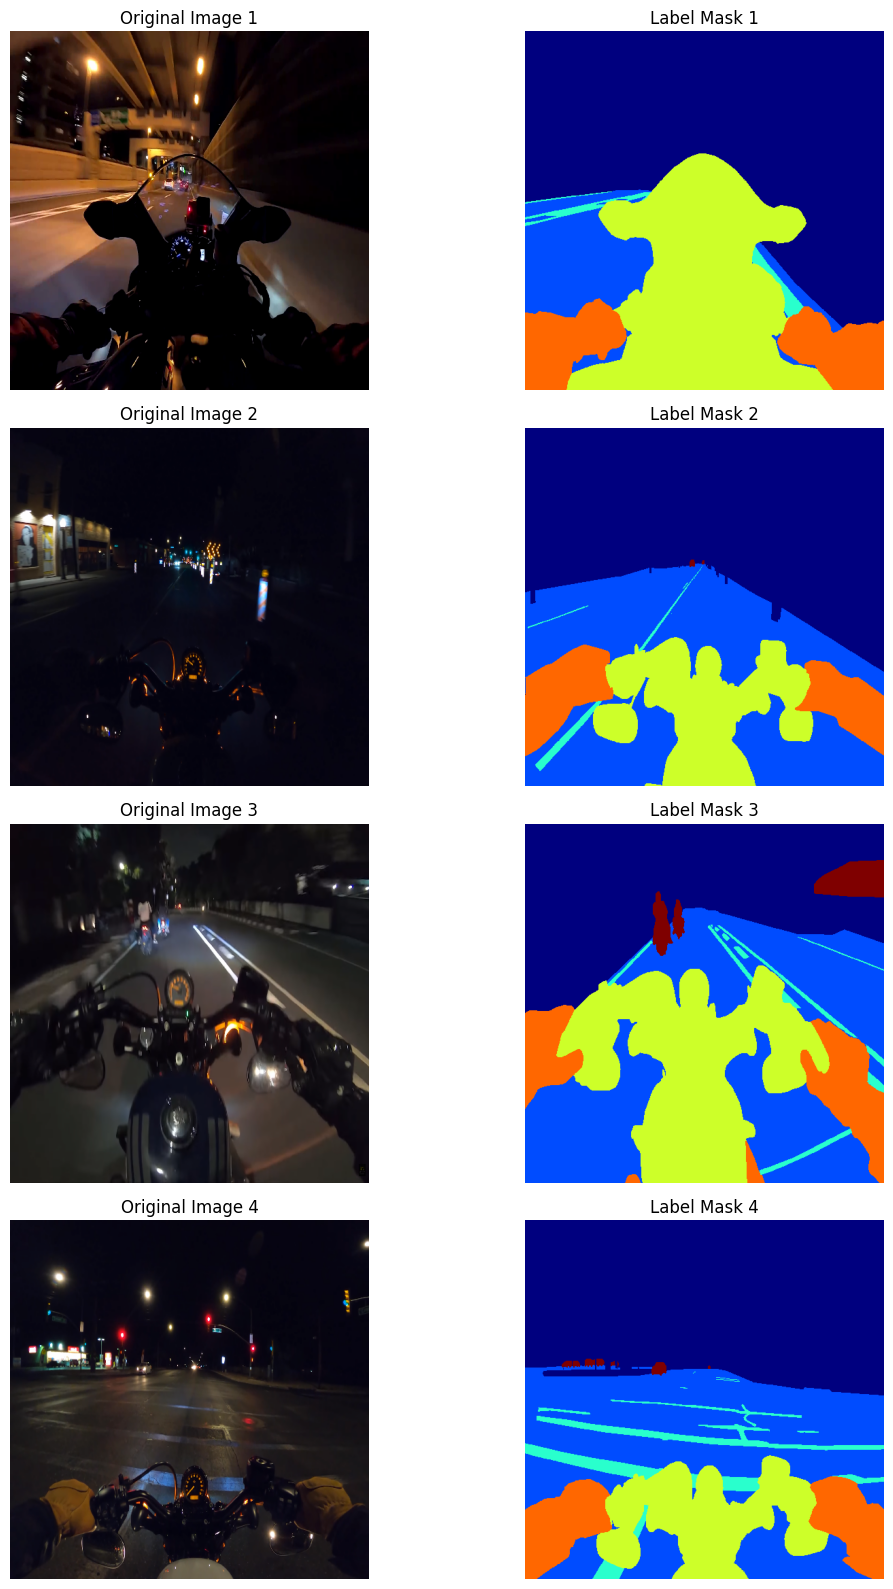

In [35]:
import matplotlib.pyplot as plt

def visualize_batch(loader, class_map):
    """마스크가 제대로 생성되었는지 시각화"""
    # 1. 배치 하나 추출
    images, masks = next(iter(loader))
    
    # 역매핑 생성 (숫자 -> 클래스 이름)
    id_to_name = {v: k for k, v in class_map.items()}
    
    # 시각화 설정 (4장 기준)
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 16))
    
    for i in range(4):
        # 이미지 전처리(Normalize) 되돌리기 (시각화 용도)
        img = images[i].permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        # 마스크 데이터
        mask = masks[i].numpy()
        
        # 출력
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Original Image {i+1}")
        axes[i, 0].axis('off')
        
        # 마스크 시각화 (클래스별로 색이 다르게 보이도록 cmap 설정)
        im = axes[i, 1].imshow(mask, cmap='jet', vmin=0, vmax=len(class_map)-1)
        axes[i, 1].set_title(f"Label Mask {i+1}")
        axes[i, 1].axis('off')
        
    plt.tight_layout()
    plt.show()

# 실행
visualize_batch(train_loader, CLASS_MAP)

#### 제대로 들어가는지 확인하기 위한 모델 정의

In [36]:
import segmentation_models_pytorch as smp

model = smp.DeepLabV3Plus(
    encoder_name="resnet34", 
    encoder_weights="imagenet", 
    in_channels=3, 
    classes=6  # 사전에 정한 6개 클래스에 맞춰 모델 생성
)

In [37]:
import torch.nn as nn
import torch.optim as optim


# 가장 기본적이면서도 확실한 기준
criterion = nn.CrossEntropyLoss() 

# 학습률(lr=0.0001)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

In [ ]:
# 1. 장치 설정: GPU가 있으면 cuda, 없으면 cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"현재 사용 중인 장치: {device}")

# 2. 모델을 해당 장치로 이동
model = model.to(device)

# 3. 학습 루프 내부에서도 데이터를 이동시켜야 함
for images, masks in train_loader:
    images = images.to(device)
    masks = masks.to(device)
    
    outputs = model(images)

    loss = criterion(outputs, masks)  # 예측값과 정답(mask) 비교
    
    loss.backward()  # 오류 역전파
    optimizer.step()  # 모델 업데이트

현재 사용 중인 장치: cuda


#### 데이터 증강 추가

In [ ]:
import cv2
import torch
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset


# 0번부터 5번까지 6개 클래스를 할당, 배경도 언Undrivable에 포함
CLASS_MAP = {
    'Undrivable': 0,
    'Road': 1,
    'Lane Mark': 2,
    'My bike': 3,
    'Rider': 4,
    'Moveable': 5
}
# 역매핑 (ID -> Name)은 필요할 때 내부에서 생성하거나 별도로 정의
ID_TO_NAME = {v: k for k, v in CLASS_MAP.items()}


class DeepLabDataset(Dataset):
    """데이터셋, 이미지 및 마스크크 리사이즈, 정규화, 텐서화 """

    def __init__(self, image_paths, json_data, class_map):
        self.image_paths = image_paths
        self.json_data = json_data
        self.class_map = class_map
        
        # 520x520 리사이즈 및 텐서 변환
        # [개선된 Transform] 
        self.transform = A.Compose([
            A.Resize(528, 528, interpolation=cv2.INTER_LINEAR),
            
            # 1. 야간 노이즈 대응 (Gaussian Noise) - "야간 데이터의 특성을 고려했습니다"
            A.GaussNoise(p=0.2),
            
            # 2. 오토바이의 좌우 주행 가변성 (Horizontal Flip)
            A.HorizontalFlip(p=0.5),
            
            # 3. 조명 변화 대응 (Random Brightness/Contrast)
            A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
            
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])
        
        # 마스크 전용 리사이즈 (정수 값 유지를 위해 별도 처리하거나 Compose 내에서 mask_interpolation 설정)
        # self.mask_resize = A.Resize(528, 528, interpolation=cv2.INTER_NEAREST)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        """마스크 제너레이터 함수로 마스크 생성, 이미지와 마스크에 리사이즈 및 정규화 적용"""
        image_path = self.image_paths[idx]
        
        # 1. 원본 이미지 로드 및 bgr2rgb
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 2. 마스크 생성 (기존에 정의한 6개 클래스 로직)
        # 2. 1920x1080 원본 크기로 먼저 생성
        full_mask = self._generate_full_mask(image_path.name, (1080, 1920))

        # 3. 이미지와 마스크 동시 변환 -> Resize(528, 528) 적용
        # 이 한 줄이 이미지와 마스크를 동기화시킵니다.
        transformed = self.transform(image=image, mask=full_mask)
        
        # 결과물에서 각각 꺼내면 이미 동기화된 상태입니다.
        image = transformed['image']
        mask = transformed['mask']
        
        return image, mask.long()

    def _generate_full_mask(self, file_name, shape):
        """JSON의 좌표를 기반으로 1080x1920 마스크 생성"""
        mask = np.zeros(shape, dtype=np.uint8)
        
        # 1. file_name으로 image_id 찾기
        image_info = next((img for img in self.json_data['images'] if img['file_name'] == file_name), None)
        if image_info is None:
            return mask
        
        image_id = image_info['id']
        
        # 2. 해당 image_id를 가진 모든 annotation 가져오기
        annotations = [ann for ann in self.json_data['annotations'] if ann['image_id'] == image_id]
        
        # 3. 카테고리 ID -> 이름 -> 인덱스(0~5) 매핑
        category_id_to_name = {cat['id']: cat['name'] for cat in self.json_data['categories']}
        
        for ann in annotations:
            cat_name = category_id_to_name.get(ann['category_id'])
            label_idx = self.class_map.get(cat_name)
            
            if label_idx is not None:
                for seg in ann['segmentation']:
                    # COCO 포맷의 폴리곤 [x1, y1, x2, y2...]을 numpy 배열로 변환
                    poly = np.array(seg).reshape((-1, 1, 2)).astype(np.int32)
                    # 해당 영역을 label_idx로 채움
                    cv2.fillPoly(mask, [poly], color=label_idx)                    
        return mask



In [ ]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

def get_loaders(images_dir, json_origin, class_map, batch_size=4):
    """위에서 PathManager 인스턴스 들이 반환한 경로 및 객체들을 인자로 입력"""

    # 해당 디렉토리와 하위 디렉토리의 모든 특정 확장자 파일을 검색 후 리스트 생성
    all_files = list(images_dir.glob("**/*.png"))

    # 2. all_files 중 'fuse'나 'save'가 경로(폴더명 포함)에 들어있는 파일 제외 후 원본 이미지만 담긴 리스트 생성
    images_path_origin = sorted([p for p in all_files if "fuse" not in str(p).lower() and "save" not in str(p).lower()])
    
    # 2. 데이터셋 분할 (160 : 20 : 20)
    train_paths, temp_paths = train_test_split(images_path_origin, train_size=160, test_size=40, random_state=42)
    val_paths, test_paths = train_test_split(temp_paths, train_size=20, test_size=20, random_state=42)

    # 3. 데이터셋 인스턴스 생성
    train_dataset = DeepLabDataset(train_paths, json_origin, class_map)
    val_dataset = DeepLabDataset(val_paths, json_origin, class_map)
    test_dataset = DeepLabDataset(test_paths, json_origin, class_map)

    # 4. 데이터로더 생성 (images, masks 구성), (batch, shuffle 결정)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(len(images_path_origin))

    return train_loader, val_loader, test_loader

# 로더 정의 완료 (train(160), val(20), test(20))
train_loader, val_loader, test_loader = get_loaders(images_dir, my_json_origin, CLASS_MAP)



200


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_augmentation_epochs(dataset, sample_idx=0, num_epochs=5):
    """동일한 샘플이 에포크마다 어떻게 변하는지 시각화"""
    fig, axes = plt.subplots(nrows=num_epochs, ncols=2, figsize=(10, 20))
    
    for epoch in range(num_epochs):
        # 동일한 인덱스를 호출하지만, 내부 transform의 p(확률)에 의해 매번 결과가 다름
        image, mask = dataset[sample_idx]
        
        # 시각화를 위한 역정규화 (Normalize 되돌리기)
        img = image.permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        # 마스크 데이터
        mask = mask.numpy()
        
        # 출력
        axes[epoch, 0].imshow(img)
        axes[epoch, 0].set_title(f"Epoch {epoch+1}: Augmented Image")
        axes[epoch, 0].axis('off')
        
        axes[epoch, 1].imshow(mask, cmap='jet')
        axes[epoch, 1].set_title(f"Epoch {epoch+1}: Corresponding Mask")
        axes[epoch, 1].axis('off')
        
    plt.tight_layout()
    plt.show()

# 실행 (이미 생성된 train_ds 사용)
# visualize_augmentation_epochs(train_ds)

In [ ]:
# 이 코드를 미리 준비해두면 "다음 담당자"에게 엄청난 도움이 됩니다.
def calculate_iou(preds, labels, num_classes=6):
    # 예측값에서 가장 높은 확률의 클래스 추출
    preds = torch.argmax(preds, dim=1)
    
    ious = []
    for cls in range(num_classes):
        intersection = ((preds == cls) & (labels == cls)).sum().item()
        union = ((preds == cls) | (labels == cls)).sum().item()
        if union == 0:
            ious.append(float('nan')) # 해당 클래스가 없는 경우
        else:
            ious.append(intersection / union)
    return ious